In [126]:
pip install -q git+https://github.com/tensorflow/examples.git


In [0]:
import tensorflow as tf
import random
from IPython.display import clear_output

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
# !rm  images/*.mat

In [0]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, dtype = tf.float32) / 255.
  input_mask -= 1
  return input_image, input_mask

In [0]:
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128,128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

  if(tf.random.uniform(()) > 0.5):
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return normalize(input_image, input_mask)

In [0]:
def load_image_test(datapoint):

  input_image = tf.image.resize(datapoint['image'], (128,128))
  input_mask =  tf.image.resize(datapoint['segmentation_mask'], (128,128))

  return normalize(input_image, input_mask)

In [0]:
sample_pixels = mpimg.imread("images/" + os.listdir("images")[0])

In [134]:
sample_pixels.shape  

(108, 144, 3)

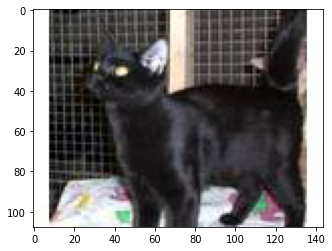

In [135]:
plt.imshow(sample_pixels)

In [136]:
ls

annotations/  annotations.tar.gz  images/  images.tar.gz  sample_data/


In [137]:
len(os.listdir("annotations/trimaps/"))

14780

In [0]:
import imageio

In [0]:
names = os.listdir("images")
masks = os.listdir("annotations/trimaps")

In [0]:
train_ratio = 0.8
train_len = int(len(names) * train_ratio)

In [0]:
x_train_names = names[:train_len]
x_test_names = names[train_len:]

In [0]:
X_train_data = []
X_train_final_names = []
for name in x_train_names:
  if len((mpimg.imread("images/" + name).shape)) == 3:
    if((mpimg.imread("images/" + name).shape)[2] == 3):
         img = tf.image.resize(mpimg.imread("images/" + name), (128,128))
         norm_img = tf.cast(img, tf.float32)/255.
         X_train_data.append(norm_img)
         X_train_final_names.append(name)

#Many images have only 2 dimensions

In [0]:
X_train_data =  np.stack(X_train_data)

In [144]:
X_train_data.shape

(5903, 128, 128, 3)

In [0]:
X_test_data = []
X_test_final_names = []
for name in x_test_names:
  if len((mpimg.imread("images/" + name).shape)) == 3:
    if((mpimg.imread("images/" + name).shape)[2] == 3):
         img = tf.image.resize(mpimg.imread("images/" + name), (128,128))
         norm_img = tf.cast(img, tf.float32)/255.
         X_test_data.append(norm_img)
         X_test_final_names.append(name)

In [0]:
X_test_data = np.stack(X_test_data)

In [147]:
X_test_data.shape

(1475, 128, 128, 3)

In [0]:
y_train_data = []
for name in X_train_final_names:
  x = name.replace(".jpg", ".png")
  # if len((mpimg.imread("annotations/trimaps/" + x))) == 3:
    # if((mpimg.imread("annotations/trimaps/" + x).shape)[2] == 3):
  pix = imageio.imread("annotations/trimaps/" + x)
  pix = tf.expand_dims(pix, -1)
  img = tf.image.resize(pix, (128,128))
  img = tf.cast(img, tf.int32)
  img -= 1
  y_train_data.append(img)

In [0]:
y_train_data = np.stack(y_train_data)

In [0]:
y_test_data = []
for name in X_test_final_names:
  x = name.replace(".jpg", ".png")
  # if len((mpimg.imread("annotations/trimaps/" + x))) == 3:
    # if((mpimg.imread("annotations/trimaps/" + x).shape)[2] == 3):
  pix = imageio.imread("annotations/trimaps/" + x)
  pix = tf.expand_dims(pix, -1)
  img = tf.image.resize(pix, (128,128))
  img = tf.cast(img, tf.int32)
  img -= 1
  y_test_data.append(img)

In [0]:
y_test_data = np.stack(y_test_data)

In [152]:
X_train_data.shape

(5903, 128, 128, 3)

In [0]:
#Sample image and mask

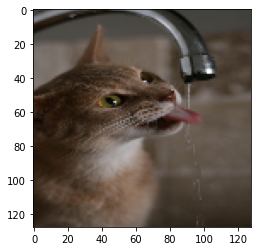

In [154]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(X_test_data[5]))

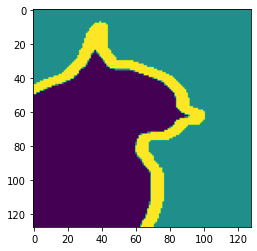

In [155]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(y_test_data[5]))

# Defining Model

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (128,128,3), include_top = False)

# Downstack layers

In [0]:
layer_names = ["block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", "block_13_expand_relu", "block_16_project"]

In [0]:
layers = [base_model.get_layer(layer).output for layer in layer_names]

In [0]:
down_stack = tf.keras.Model(inputs = base_model.input, outputs = layers)

In [0]:
down_stack.trainable = False

In [161]:
pip install -q git+https://github.com/tensorflow/examples.git

# Upstack layers

In [0]:
from tensorflow_examples.models.pix2pix import pix2pix

In [0]:
upstack = [pix2pix.upsample(512,3),
           pix2pix.upsample(256,3),
           pix2pix.upsample(128,3),
           pix2pix.upsample(64,3)]

# Modified U-Net

In [0]:
def u_net_model(output_channels):
  inputs = tf.keras.layers.Input(shape = (128,128,3))
  x = inputs

  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up,skip in zip(upstack, skips):
    x = up(x)
    print(x.shape)
    print("First upstack done")
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
    print(x.shape)
    print("concat done")
  
  last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides = 2, padding="same")
  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x )

In [165]:
model = u_net_model(3)

(None, 8, 8, 512)
First upstack done
(None, 8, 8, 1088)
concat done
(None, 16, 16, 256)
First upstack done
(None, 16, 16, 448)
concat done
(None, 32, 32, 128)
First upstack done
(None, 32, 32, 272)
concat done
(None, 64, 64, 64)
First upstack done
(None, 64, 64, 160)
concat done


In [0]:
model.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['acc'])

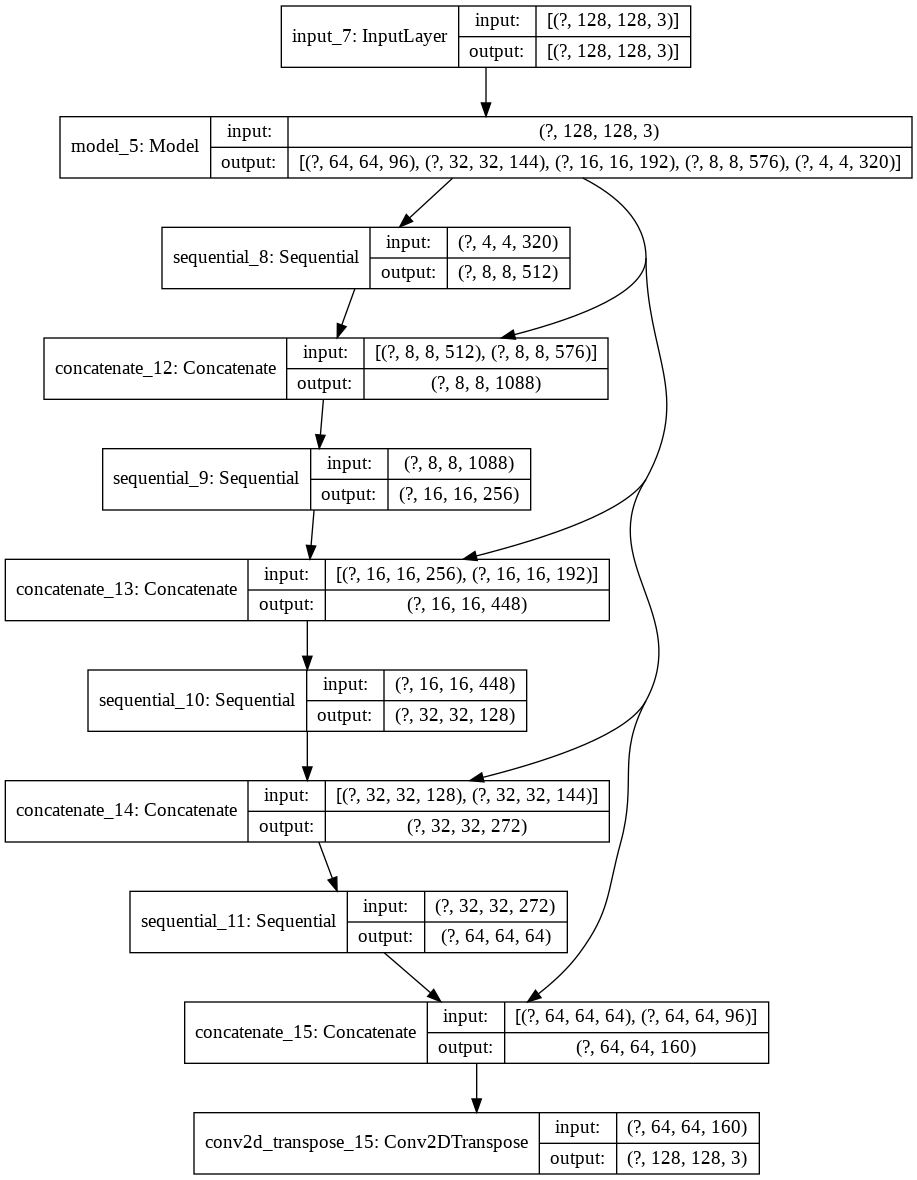

In [167]:
tf.keras.utils.plot_model(model, show_shapes = True)

# Helper Functions

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [0]:
def show_predictions(dataset = None): 
    x = random.randint(1,1000)
    pred_mask = model.predict(tf.expand_dims(X_test_data[x], 0))
    pred_mask = create_mask(pred_mask)
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(y_test_data[x]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img((pred_mask)))
    plt.show()

# Prediction before fitting the model

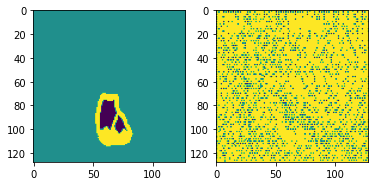

In [170]:
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


# Training the model

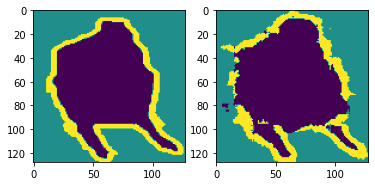


Sample Prediction after epoch 2

185/185 [==============================] - 13s 68ms/step - loss: 0.1467 - acc: 0.9420 - val_loss: 0.2953 - val_acc: 0.9041


In [177]:
model_history = model.fit(X_train_data, y_train_data, epochs = 2, validation_data = (X_test_data, y_test_data), callbacks = [DisplayCallback()])

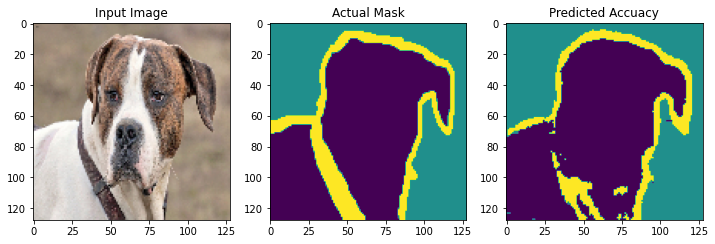

In [189]:
plt.figure(figsize = (12,10))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(tf.keras.preprocessing.image.array_to_img(X_test_data[4]))
plt.subplot(1,3,2)
plt.title("Actual Mask")
plt.imshow(tf.keras.preprocessing.image.array_to_img(y_test_data[4]))
plt.subplot(1,3,3)
plt.title("Predicted Accuacy")
pred_mask = model.predict(tf.expand_dims(X_test_data[4], 0))
pred_mask = create_mask(pred_mask)
plt.imshow(tf.keras.preprocessing.image.array_to_img((pred_mask)))

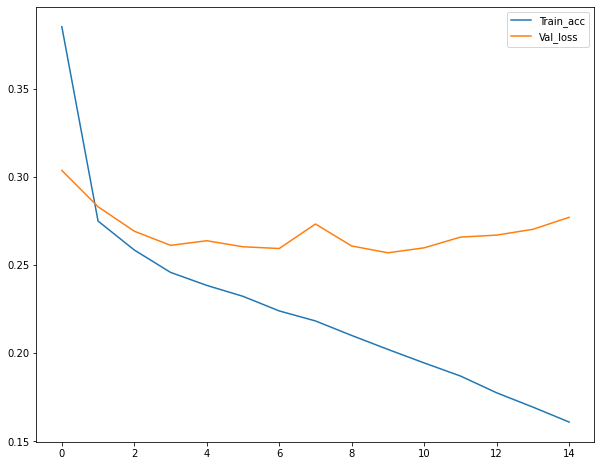

In [174]:
plt.figure(figsize = (10,8))
plt.plot(model_history.history['loss'], label = "Train_acc")
plt.plot(model_history.history['val_loss'], label = "Val_loss")
plt.legend()